# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Instal dan Konfigurasi Kaggle

In [ ]:
from google.colab import files

# Unggah file kaggle.json
files.upload()

# Konfigurasi API Kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


# Ekstrak Dataset

In [ ]:
!kaggle datasets download -d alessiocorrado99/animals10

import zipfile
with zipfile.ZipFile("animals10.zip", 'r') as zip_ref:
    zip_ref.extractall("animals10")

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
100% 585M/586M [00:28<00:00, 23.0MB/s]
100% 586M/586M [00:28<00:00, 21.2MB/s]


# Persiapan Data

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Direktori dataset
base_dir = 'animals10/raw-img'

# Konfigurasi ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% training, 20% validation
    horizontal_flip=True,  # Augmentasi tambahan
    zoom_range=0.2
)

# Dataset training
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Dataset validasi
validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # Shuffle False untuk evaluasi
)

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


# Membangun Model

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load MobileNetV2 dengan bobot pre-trained dari ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze semua layer pada base model
base_model.trainable = False

# Tambahkan lapisan custom
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Kompilasi model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Callback untuk Optimasi

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Model checkpoint
model_checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/animals_model/transfer_model.keras",
    monitor='val_loss',
    save_best_only=True
)

# Model Training

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 317s 478ms/step - accuracy: 0.9164 - loss: 0.2672 - val_accuracy: 0.9467 - val_loss: 0.1700
Epoch 2/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 302s 458ms/step - accuracy: 0.9279 - loss: 0.2297 - val_accuracy: 0.9434 - val_loss: 0.1836
Epoch 3/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 323s 456ms/step - accuracy: 0.9316 - loss: 0.2223 - val_accuracy: 0.9522 - val_loss: 0.1643
Epoch 4/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 320s 457ms/step - accuracy: 0.9308 - loss: 0.2219 - val_accuracy: 0.9480 - val_loss: 0.1636
Epoch 5/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 303s 460ms/step - accuracy: 0.9375 - loss: 0.2094 - val_accuracy: 0.9509 - val_loss: 0.1577
Epoch 6/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 301s 456ms/step - accuracy: 0.9331 - loss: 0.2110 - val_accuracy: 0.9482 - val_loss: 0.1707
Epoch 7/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 324s 459ms/step - accuracy: 0.9355 - loss: 0.2110 - val_accuracy: 0.9503 - val_loss: 0.1677
Epoch 8/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 319s 452ms/step - accuracy: 0.9359 -

# Visualisasi

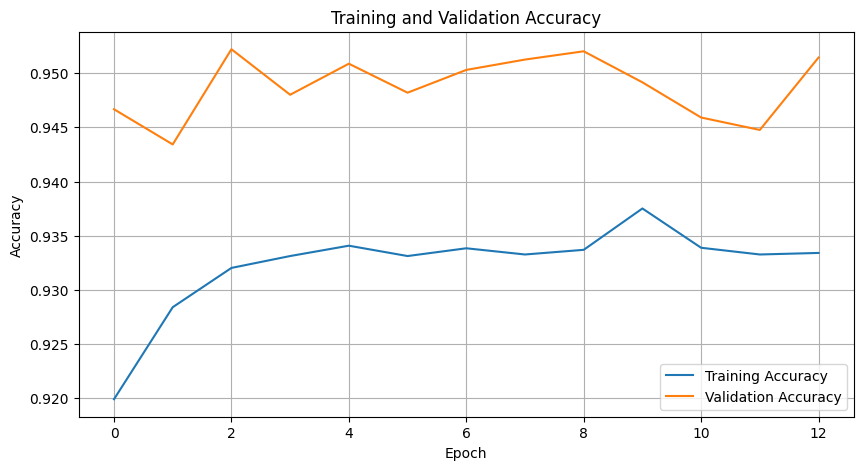

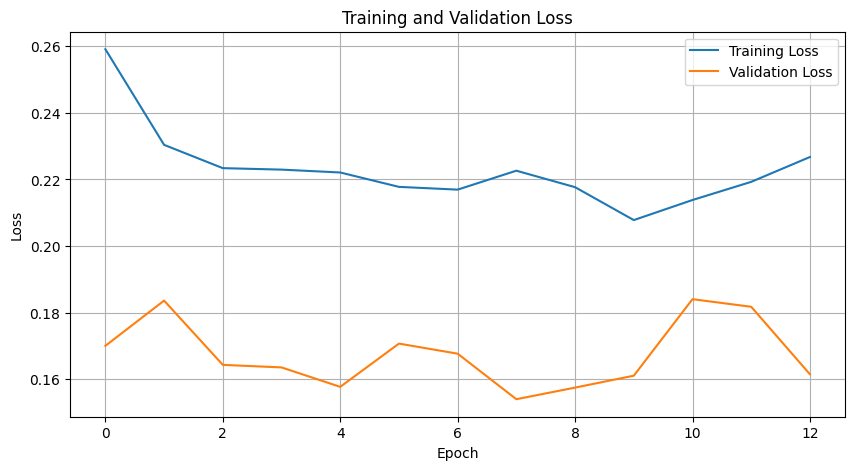

In [ ]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluasi

In [ ]:
loss, accuracy = model.evaluate(validation_generator, verbose=1)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

164/164 ━━━━━━━━━━━━━━━━━━━━ 59s 358ms/step - accuracy: 0.9503 - loss: 0.1736
Validation Loss: 0.1572
Validation Accuracy: 0.9505


# Confusion Matrix dan Classification Report

164/164 ━━━━━━━━━━━━━━━━━━━━ 62s 362ms/step


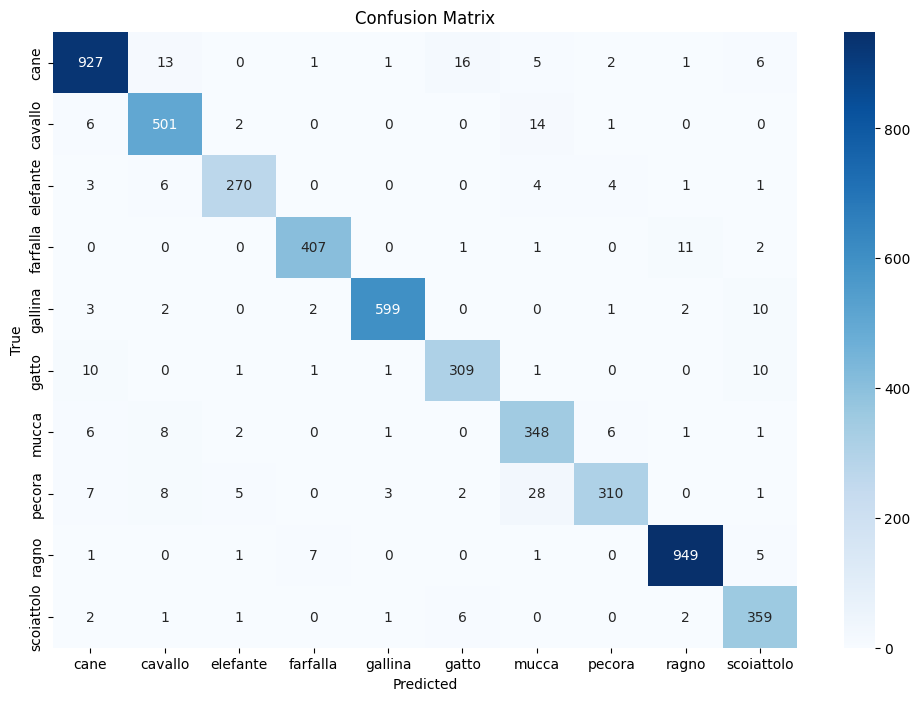

Classification Report:

              precision    recall  f1-score   support

        cane       0.96      0.95      0.96       972
     cavallo       0.93      0.96      0.94       524
    elefante       0.96      0.93      0.95       289
    farfalla       0.97      0.96      0.97       422
     gallina       0.99      0.97      0.98       619
       gatto       0.93      0.93      0.93       333
       mucca       0.87      0.93      0.90       373
      pecora       0.96      0.85      0.90       364
       ragno       0.98      0.98      0.98       964
  scoiattolo       0.91      0.97      0.94       372

    accuracy                           0.95      5232
   macro avg       0.94      0.94      0.94      5232
weighted avg       0.95      0.95      0.95      5232



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Prediksi pada data validasi
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

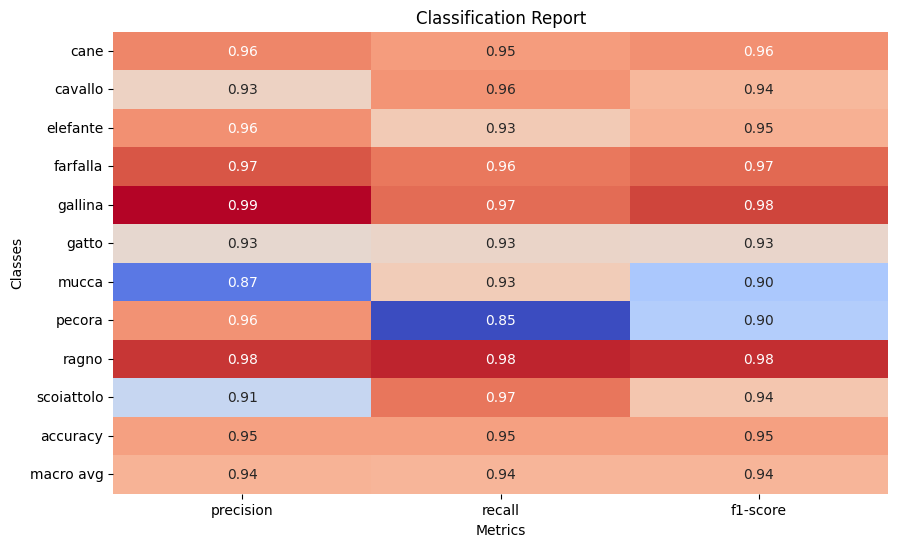

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Classification report
report = classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys(), output_dict=True)

# Konversi ke DataFrame
report_df = pd.DataFrame(report).transpose()

# Plot sebagai heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
plt.title("Classification Report")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Menyimpan Model

In [ ]:
model.save('model.h5')

In [ ]:
import numpy as np

# Mendapatkan bobot model
weights = model.get_weights()

# Definisikan class names dalam bahasa Italia
class_names_italian = [
    "cane", "cavallo", "elefante", "farfalla", "gallina",
    "gatto", "mucca", "pecora", "ragno", "scoiattolo"
]

# Gabungkan bobot model dan nama kelas dalam dictionary
model_data = {
    "weights": weights,
    "class_names": class_names_italian
}

# Simpan ke dalam file .npy
np.save("model_and_classes_italian.npy", model_data)

In [ ]:
import numpy as np

# Mendapatkan bobot model
weights = model.get_weights()

# Definisikan class names dalam bahasa Italia
class_names_italian = [
    "cane", "cavallo", "elefante", "farfalla", "gallina",
    "gatto", "mucca", "pecora", "ragno", "scoiattolo"
]

# Translate class names from Italian to English
translate = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "ragno": "spider",
    "scoiattolo": "squirrel"
}

# Ganti class names menjadi bahasa Inggris
class_names_english = [translate[class_name] for class_name in class_names_italian]

# Gabungkan bobot model dan nama kelas dalam dictionary
model_data = {
    "weights": weights,
    "class_names": class_names_english
}

# Simpan ke dalam file .npy
np.save("model_and_classes_english.npy", model_data)